# Chapter #4 - Getting started with neural networks: Classification and regression

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.datasets import imdb, reuters
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from data_playground.model_selection_toolbox import *
from copy import copy

## 4.1. Classifying movie reviews: A binary classification example

### 4.1.1. The IMDB dataset

> - Already comes packaged with Keras. 
> - 50,000 highly polarized reviews from the Internet Movie Database.
> - They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

In [2]:
# Load & split the data into train & test sets
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

> - The argument `num_words=10000` means you’ll only keep the top 10,000 most frequently occurring words in the training data.
> - The variables `train_data` and `test_data` are lists of reviews; each review is a list of word indices (encoding a sequence of words).
> - The variables `train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive.

In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [4]:
print(train_labels[0])

1


> - Because we’re restricting ourselves to the top 10,000 most frequent words, no word index will exceed 10,000.

In [5]:
max([max(sequence) for sequence in train_data])

9999

> - For kicks, here’s how you can quickly decode one of these reviews back to English words:

In [6]:
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index() 

# Print some key-value pairs from word_index
i = 0
for k, v in word_index.items():
    if i > 4:
        break
    print(f"{k}: {v}")
    i+=1

fawn: 34701
tsukino: 52006
nunnery: 52007
sonja: 16816
vani: 63951


In [7]:
# Reverses it, mapping integer indices to words
reverse_word_index = {v: k for k, v in word_index.items()}

# Print some key-value pairs from reverse_word_index
i = 0
for k, v in reverse_word_index.items():
    if i > 4:
        break
    print(f"{k}: {v}")
    i+=1

34701: fawn
52006: tsukino
52007: nunnery
16816: sonja
63951: vani


In [8]:
# Decodes the review
decoded_review = " ".join([reverse_word_index.get(i-3, '??') for i in train_data[0]])
decoded_review

"?? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ?? is an amazing actor and now the same being director ?? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ?? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ?? to the two little boy's that played the ?? of norman and paul they were just brilliant children are often left out of the ?? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't

> - Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown”.

### 4.1.2. Preparing the data

> - You can’t directly feed lists of integers into a neural network, they all have different lengths, but a neural network expects to process contiguous batches of data.
> - You have to turn your lists into tensors, there are two ways to do that:
>> 1. Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, max_length), and start your model with a layer capable of handling such integer tensors.
>> 2. Multi-hot encode your lists to turn them into vectors of 0s and 1s, then you could use a Dense layer, capable of handling floating-point vector data, as the first layer in your model.
> - Let’s go with the latter solution to vectorize the data.

In [9]:
def vectorize_sequences(sequences, dimension=10000):
    
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    
    # Sets specific indices of results to 1s
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1
    
    # Return results
    return results

In [10]:
%%time
# Vectorize train & test data
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)
X_train.shape, X_test.shape

CPU times: total: 11.5 s
Wall time: 12.1 s


((25000, 10000), (25000, 10000))

In [11]:
# Vectorize train & test labels
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")
y_train.shape, y_test.shape

((25000,), (25000,))

### 4.1.3. Building the model

> - The input data is vectors, and the labels are scalars (1s and 0s).
> - A type of model that performs well on such a problem is a plain stack of densely connected (Dense) layers with relu activations.
> - There are two key architecture decisions to be made:
>> 1. How many layers to use,
>> 2. How many units to choose for each layer.
> - For the time being, you’ll have to trust me (the author) with the following architecture choices:
>> - Two intermediate layers with 16 units each.
>> - A third layer that will output the scalar prediction regarding the sentiment of the current review.

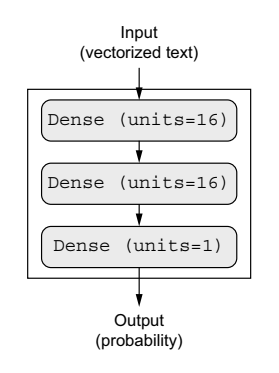

In [12]:
# Initialize the model
model = Sequential([Dense(16, activation='relu'),
                    Dense(16, activation='relu'),
                    Dense(1, activation='sigmoid')])

> - Having 16 units means the weight matrix `W` will have shape (input_dimension, 16).
> - Having more units (a higher-dimensional representation space) allows your model to learn more-complex representations, but it makes the model more computationally expensive and may lead to learning unwanted patterns.
> - The intermediate layers use relu as their activation function, and the final layer uses a sigmoid activation so as to output a probability.
> - Finally, you need to choose a loss function and an optimizer.

In [13]:
# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 4.1.4. Validating your approach

> - A deep learning model should never be evaluated on its training data.
> - It’s standard practice to use a validation set to monitor the accuracy of the model during training.
> - Here, we’ll create a validation set by setting apart 10,000 samples from the original training data.

In [14]:
# Split the train set into new train set & val set
partial_X_train, partial_y_train, X_val, y_val = train_val_split(X_train, y_train, n_splits=10000, shuffle=True)

In [15]:
partial_X_train.shape, partial_y_train.shape

((15000, 10000), (15000,))

In [16]:
X_val.shape, y_val.shape

((10000, 10000), (10000,))

> - We will now train the model for 20 epochs (20 iterations over all samples in the training data) in mini-batches of 512 samples.
> - At the same time, we will monitor loss and accuracy on the 10,000 samples that we set apart by passing the validation data as the validation_data argument.

In [17]:
# Fit the model
model_hx = model.fit(partial_X_train, partial_y_train,
                     epochs=20, batch_size=512,
                     validation_data=(X_val, y_val))

Epoch 1/20
30/30 [==============================] - 6s 108ms/step - loss: 0.5283 - accuracy: 0.7831 - val_loss: 0.3975 - val_accuracy: 0.8714
Epoch 2/20
30/30 [==============================] - 2s 62ms/step - loss: 0.3226 - accuracy: 0.8990 - val_loss: 0.3194 - val_accuracy: 0.8818
Epoch 3/20
30/30 [==============================] - 1s 42ms/step - loss: 0.2387 - accuracy: 0.9254 - val_loss: 0.3000 - val_accuracy: 0.8810
Epoch 4/20
30/30 [==============================] - 1s 35ms/step - loss: 0.1862 - accuracy: 0.9401 - val_loss: 0.2839 - val_accuracy: 0.8877
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1531 - accuracy: 0.9516 - val_loss: 0.2803 - val_accuracy: 0.8894
Epoch 6/20
30/30 [==============================] - 1s 36ms/step - loss: 0.1235 - accuracy: 0.9635 - val_loss: 0.3555 - val_accuracy: 0.8661
Epoch 7/20
30/30 [==============================] - 1s 34ms/step - loss: 0.1043 - accuracy: 0.9694 - val_loss: 0.2951 - val_accuracy: 0.8882
Epoch 8/20
3

> - The call to `model.fit()` returns a History object.
> - This object has a member history, which is a dictionary containing data about everything that happened during training.
> - The dictionary contains four entries: one per metric that was being monitored during training and during validation.

In [18]:
type(model_hx)

keras.callbacks.History

In [19]:
hx_dict = model_hx.history
hx_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [20]:
n_iters = len(hx_dict['loss'])

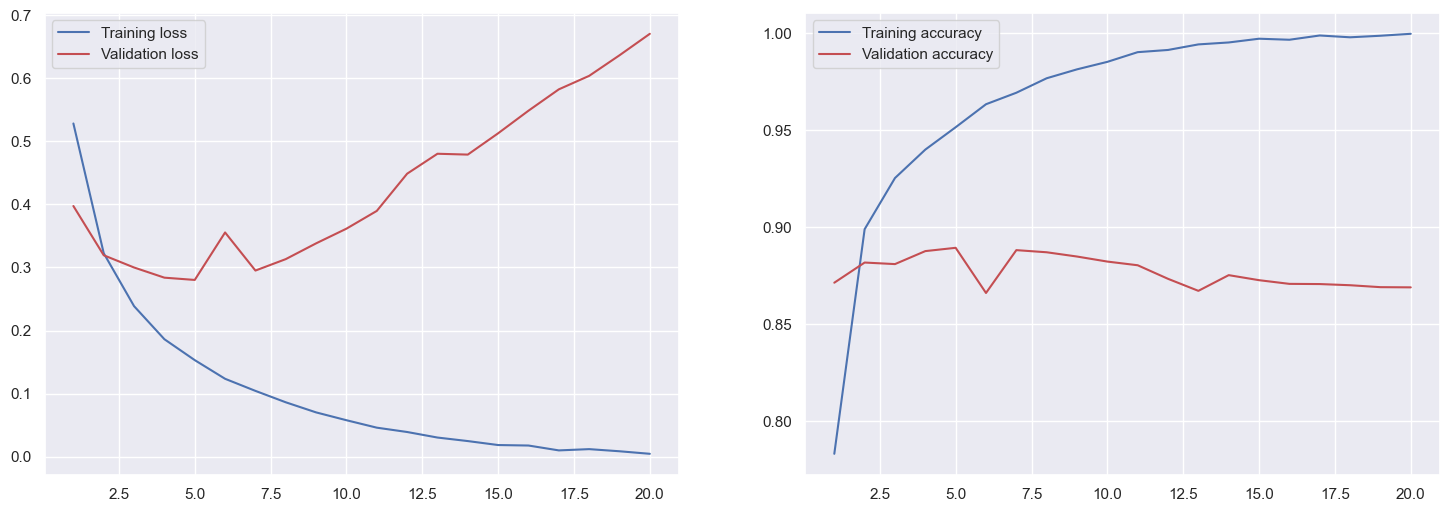

In [21]:
# Plot the loss data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['loss'], label='Training loss', color='b', ax=ax1)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_loss'], label='Validation loss', color='r', ax=ax1)

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['accuracy'], label='Training accuracy', color='b', ax=ax2)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_accuracy'], label='Validation accuracy', color='r', ax=ax2);

> - The training loss decreases with every epoch, and the training accuracy increases with every epoch.
> - But that isn’t the case for the validation loss and accuracy!
>> - They seem to peak at the fourth epoch.
>> - After the fourth epoch, you’re overoptimizing on the training data, and you end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.
> - In this case, to prevent overfitting, you could stop training after four epochs.

In [22]:
# Initialize another model
another_model = Sequential([Dense(16, activation='relu'),
                            Dense(16, activation='relu'),
                            Dense(1, activation='sigmoid')])

In [23]:
# Compile the model
another_model.compile(loss='binary_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])

In [24]:
# Fit the model
model_hx = model.fit(partial_X_train, partial_y_train,
                     epochs=4, batch_size=512,
                     validation_data=(X_val, y_val))

Epoch 1/4
30/30 [==============================] - 3s 93ms/step - loss: 0.0057 - accuracy: 0.9992 - val_loss: 0.7004 - val_accuracy: 0.8679
Epoch 2/4
30/30 [==============================] - 2s 69ms/step - loss: 0.0027 - accuracy: 0.9998 - val_loss: 0.7515 - val_accuracy: 0.8675
Epoch 3/4
30/30 [==============================] - 1s 43ms/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.7750 - val_accuracy: 0.8690
Epoch 4/4
30/30 [==============================] - 1s 32ms/step - loss: 0.0016 - accuracy: 0.9999 - val_loss: 0.8049 - val_accuracy: 0.8687


In [25]:
hx_dict = model_hx.history
n_iters = len(hx_dict['loss'])

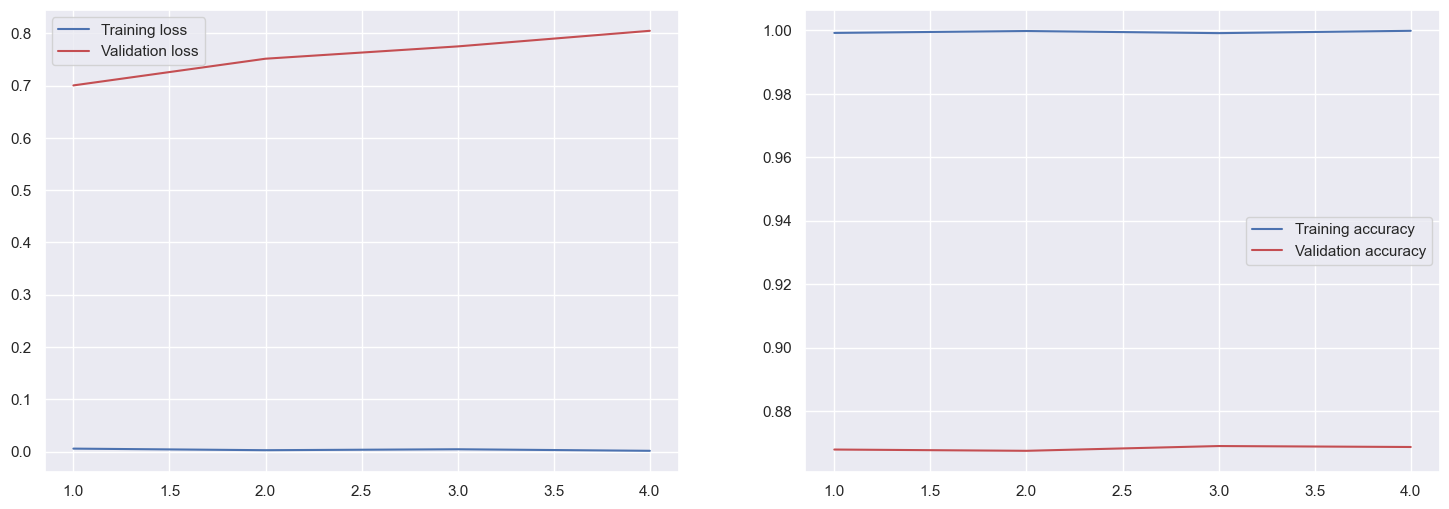

In [26]:
# Plot the loss data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['loss'], label='Training loss', color='b', ax=ax1)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_loss'], label='Validation loss', color='r', ax=ax1)

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['accuracy'], label='Training accuracy', color='b', ax=ax2)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_accuracy'], label='Validation accuracy', color='r', ax=ax2);

### 4.1.5. Using a trained model to generate predictions on new data

> - You can generate the likelihood of reviews being positive by using the `predict` method.

In [27]:
# Make predictions using the test set
another_model.predict(X_test)

782/782 [==============================] - 6s 7ms/step


array([[0.49968538],
       [0.5109293 ],
       [0.50836104],
       ...,
       [0.5063223 ],
       [0.504301  ],
       [0.497311  ]], dtype=float32)

> - As you can see, the model is confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4)

### 4.1.6. Further experiments

> - There’s still room for improvement:
>> - Try using one or three representation layers, and see how doing so affects validation and test accuracy.
>> - Try using layers with more units or fewer units: 32 units, 64 units, and so on.
>> - Try using the mse loss function instead of binary_crossentropy.
>> - Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

### 4.1.7. Wrapping up

> - Here’s what you should take away from this example:
>> - In a binary classification problem (two output classes), your model should end with a `Dense` layer with one unit and a `sigmoid` activation: the output of your model should be a scalar between 0 and 1, encoding a probability.
>> - With such a scalar sigmoid output on a binary classification problem, the loss function you should use is `binary_crossentropy`.
>> - The `rmsprop` optimizer is generally a good enough choice, whatever your problem.
>> - As they get better on their training data, neural networks eventually start overfitting and end up obtaining increasingly worse results on data they’ve never
seen before. 

## 4.2. Classifying newswires: A multiclass classification example

### 4.2.1. The Reuters dataset

> - A set of short newswires and their topics, published by Reuters in 1986.
> - 46 different topics; some topics are more represented than others, but each topic has at least 10 examples in the training set.
> - Comes packaged as part of Keras. 

In [28]:
# Load & split the data into train & test sets
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

> - As with the IMDB dataset, the argument num_words=10000 restricts the data to the 10,000 most frequently occurring words found in the data.
> - As with the IMDB reviews, each example is a list of integers.

### 4.2.2. Preparing the data

> - You can vectorize the data with the exact same code as in the previous example.

In [29]:
%%time
# Vectorize train & test data
X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)
X_train.shape, X_test.shape

CPU times: total: 3.53 s
Wall time: 3.79 s


((8982, 10000), (2246, 10000))

> - To vectorize the labels, there are two possibilities:
>> 1. You can cast the label list as an integer tensor,
>> 2. You can use one-hot encoding.
> - One-hot encoding is a widely used format for categorical data, also called categorical encoding.
> - In this case, one-hot encoding of the labels consists of embedding each label as an all-zero vector with a 1 in the place of the label index.

In [30]:
def to_one_hot(labels, dimension=46):
    
    # Creates an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(labels), dimension))
    
    # Sets specific indices of results to 1s
    for i, label in enumerate(labels):
        results[i, label] = 1
    
    # Return results
    return results

In [31]:
%%time
# Vectorize train & test labels
y_train = to_one_hot(train_labels)
y_test = to_one_hot(test_labels)
y_train.shape, y_test.shape

CPU times: total: 62.5 ms
Wall time: 32 ms


((8982, 46), (2246, 46))

> - Note that there is a built-in way to do this in Keras.

In [32]:
%%time
# Vectorize train & test labels
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
y_train.shape, y_test.shape

CPU times: total: 0 ns
Wall time: 7.99 ms


((8982, 46), (2246, 46))

### 4.2.3. Building your model

> - This topic-classification problem looks similar to the previous movie-review classification problem:
>> - In both cases, we’re trying to classify short snippets of text.
>> - But there is a new constraint here: the number of output classes has gone from 2 to 46 (**the dimensionality of the output space is much larger**).
> - In a stack of Dense layers like those we’ve been using, each layer can only access information present in the output of the previous layer, **if one layer drops some information relevant to the classification problem, this information can never be recovered by later layers**.
> -  In the previous example, we used 16-dimensional intermediate layers, **but a 16-dimensional space may be too limited to learn to separate 46 different classes**, let’s go with 64 units.

In [33]:
# Initialize the model
model = Sequential([Dense(64, activation='relu'),
                    Dense(64, activation='relu'),
                    Dense(46, activation='softmax')])

> - There are two other things you should note about this architecture:
>> - First, we end the model with a Dense layer of size 46, each entry in this vector (each dimension) will encode a different output class.
>> - Second, the last layer uses a softmax activation.
> - The best loss function to use in this case is `categorical_crossentropy`, iIt measures the distance between two probability distributions: here, between the probability distribution output by the model and the true distribution of the labels.

In [34]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

### 4.2.4. Validating your approach

> - Let’s set apart 1,000 samples in the training data to use as a validation set.

In [35]:
# Split the train set into new train set & val set
partial_X_train, partial_y_train, X_val, y_val = train_val_split(X_train, y_train, n_splits=1000, shuffle=True)

> - let’s train the model for 20 epochs.

In [36]:
# Fit the model
model_hx = model.fit(partial_X_train, partial_y_train,
                     epochs=20, batch_size=512,
                     validation_data=(X_val, y_val))

Epoch 1/20
16/16 [==============================] - 5s 141ms/step - loss: 2.7031 - accuracy: 0.5078 - val_loss: 1.7774 - val_accuracy: 0.6580
Epoch 2/20
16/16 [==============================] - 2s 119ms/step - loss: 1.4342 - accuracy: 0.7006 - val_loss: 1.2963 - val_accuracy: 0.7260
Epoch 3/20
16/16 [==============================] - 1s 76ms/step - loss: 1.0426 - accuracy: 0.7745 - val_loss: 1.1289 - val_accuracy: 0.7660
Epoch 4/20
16/16 [==============================] - 1s 57ms/step - loss: 0.8184 - accuracy: 0.8245 - val_loss: 1.0275 - val_accuracy: 0.7840
Epoch 5/20
16/16 [==============================] - 1s 47ms/step - loss: 0.6555 - accuracy: 0.8654 - val_loss: 0.9855 - val_accuracy: 0.7980
Epoch 6/20
16/16 [==============================] - 1s 48ms/step - loss: 0.5210 - accuracy: 0.8964 - val_loss: 0.9300 - val_accuracy: 0.8120
Epoch 7/20
16/16 [==============================] - 1s 48ms/step - loss: 0.4177 - accuracy: 0.9168 - val_loss: 0.9061 - val_accuracy: 0.8230
Epoch 8/20


In [37]:
hx_dict = model_hx.history
n_iters = len(hx_dict['loss'])

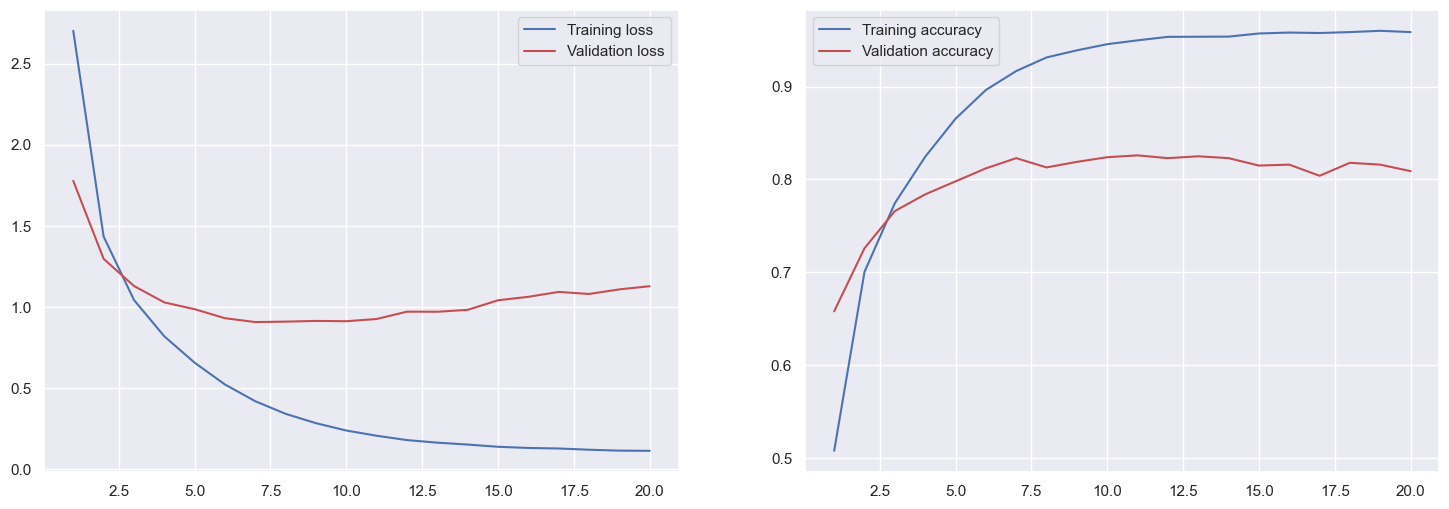

In [38]:
# Plot the loss data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['loss'], label='Training loss', color='b', ax=ax1)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_loss'], label='Validation loss', color='r', ax=ax1)

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['accuracy'], label='Training accuracy', color='b', ax=ax2)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_accuracy'], label='Validation accuracy', color='r', ax=ax2);

> - The model begins to overfit after nine epochs.
> - Let’s train a new model from scratch for nine epochs and then evaluate it on the test set.

In [39]:
# Initialize the model
another_model = Sequential([Dense(64, activation='relu'),
                            Dense(64, activation='relu'),
                            Dense(46, activation='softmax')])

In [40]:
# Compile the model
another_model.compile(loss='categorical_crossentropy',
                      optimizer='rmsprop',
                      metrics=['accuracy'])

In [41]:
# Fit the model
model_hx = another_model.fit(partial_X_train, partial_y_train,
                             epochs=9, batch_size=512,
                             validation_data=(X_val, y_val))

Epoch 1/9
16/16 [==============================] - 5s 163ms/step - loss: 2.6677 - accuracy: 0.5175 - val_loss: 1.7486 - val_accuracy: 0.6590
Epoch 2/9
16/16 [==============================] - 2s 113ms/step - loss: 1.4367 - accuracy: 0.7088 - val_loss: 1.3143 - val_accuracy: 0.7340
Epoch 3/9
16/16 [==============================] - 1s 76ms/step - loss: 1.0637 - accuracy: 0.7766 - val_loss: 1.1496 - val_accuracy: 0.7710
Epoch 4/9
16/16 [==============================] - 1s 55ms/step - loss: 0.8407 - accuracy: 0.8237 - val_loss: 1.1219 - val_accuracy: 0.7580
Epoch 5/9
16/16 [==============================] - 1s 49ms/step - loss: 0.6748 - accuracy: 0.8586 - val_loss: 1.0007 - val_accuracy: 0.7980
Epoch 6/9
16/16 [==============================] - 1s 49ms/step - loss: 0.5464 - accuracy: 0.8881 - val_loss: 0.9591 - val_accuracy: 0.8050
Epoch 7/9
16/16 [==============================] - 1s 49ms/step - loss: 0.4353 - accuracy: 0.9112 - val_loss: 0.9663 - val_accuracy: 0.8060
Epoch 8/9
16/16 [=

In [42]:
hx_dict = model_hx.history
n_iters = len(hx_dict['loss'])

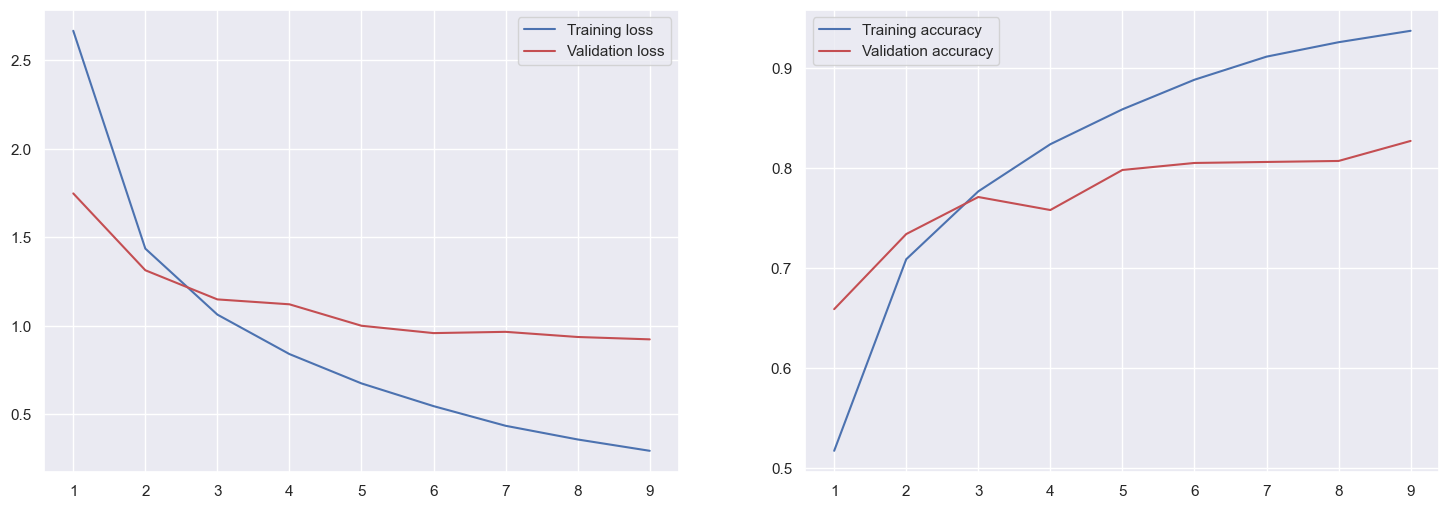

In [43]:
# Plot the loss data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['loss'], label='Training loss', color='b', ax=ax1)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_loss'], label='Validation loss', color='r', ax=ax1)

sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['accuracy'], label='Training accuracy', color='b', ax=ax2)
sns.lineplot(x=np.arange(1, n_iters+1), y=hx_dict['val_accuracy'], label='Validation accuracy', color='r', ax=ax2);

> - Here are the final results:

In [44]:
# Evaluate the model performance
results = another_model.evaluate(X_test, y_test)

71/71 [==============================] - 1s 10ms/step - loss: 0.9941 - accuracy: 0.7885


> - This approach reaches an accuracy of ~80%.
> - With a balanced binary classification problem, the accuracy reached by a purely random classifier would be 50%.
But in this case, we have 46 classes, and they may not be equally represented, **what would be the accuracy of a random baseline?**
> - We could try quickly implementing one to check this empirically:

In [45]:
# Implement a baseline classifier
test_labels_copied = copy(test_labels)
means = np.zeros(10)
rng = np.random.default_rng(42)

for i in range(10):
    rng.shuffle(test_labels_copied)
    hits_array = (np.array(test_labels) == np.array(test_labels_copied))
    means[i] = hits_array.mean()
    
means.mean()

0.1827248441674087

### 4.2.5. Generating predictions on new data

> - Let’s generate topic predictions for all of the test data:

In [46]:
predictions = model.predict(X_test)

71/71 [==============================] - 1s 9ms/step


Each entry in `predictions` is a vector of length 46:

In [47]:
predictions[0].shape

(46,)

> - The coefficients in this vector sum to 1, as they form a probability distribution:

In [48]:
predictions[0].sum()

1.0

> - The largest entry is the predicted class—the class with the highest probability:

In [49]:
np.argmax(predictions[0])

3

### 4.2.6. A different way to handle the labels and the loss

> - There is another way to encode the labels, it would be to cast them as an integer tensor.

In [50]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

> - The only thing this approach would change is the choice of the loss function.
> - The loss function used before, `categorical_crossentropy`, expects the labels to follow a categorical encoding.
> - With integer labels, you should use `sparse_categorical_crossentropy`, this new loss function is still mathematically the same as categorical_crossentropy, it just has a different interface.

### 4.2.7. The importance of having sufficiently large intermediate layers

> - Because the final outputs are 46-dimensional, you should avoid intermediate layers with many fewer than 46 units.
> - Let’s see what happens when we introduce an information bottleneck by having intermediate layers that are significantly less than 46-dimensional (for example, 4-dimensional):

In [51]:
# Initialize the model
model = Sequential([Dense(64, activation='relu'),
                    Dense(4, activation='relu'),
                    Dense(46, activation='softmax')])

In [52]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [53]:
# Fit the model
model_hx = model.fit(partial_X_train, partial_y_train,
                     epochs=20, batch_size=128,
                     validation_data=(X_val, y_val))

Epoch 1/20
63/63 [==============================] - 5s 47ms/step - loss: 3.5598 - accuracy: 0.2598 - val_loss: 3.3293 - val_accuracy: 0.3050
Epoch 2/20
63/63 [==============================] - 3s 46ms/step - loss: 3.0343 - accuracy: 0.4444 - val_loss: 2.8703 - val_accuracy: 0.3900
Epoch 3/20
63/63 [==============================] - 2s 25ms/step - loss: 2.5595 - accuracy: 0.3396 - val_loss: 2.4649 - val_accuracy: 0.3450
Epoch 4/20
63/63 [==============================] - 1s 22ms/step - loss: 2.0752 - accuracy: 0.3741 - val_loss: 1.9456 - val_accuracy: 0.3680
Epoch 5/20
63/63 [==============================] - 1s 21ms/step - loss: 1.5124 - accuracy: 0.5817 - val_loss: 1.5351 - val_accuracy: 0.6630
Epoch 6/20
63/63 [==============================] - 1s 20ms/step - loss: 1.2076 - accuracy: 0.7142 - val_loss: 1.4149 - val_accuracy: 0.6720
Epoch 7/20
63/63 [==============================] - 1s 20ms/step - loss: 1.0822 - accuracy: 0.7280 - val_loss: 1.3984 - val_accuracy: 0.6870
Epoch 8/20
63

In [54]:
hx_dict = model_hx.history
np.array(hx_dict['val_accuracy']).max()

0.6909999847412109

> - This drop is mostly due to the fact that we’re trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional.
> - The model is able to cram most of the necessary information into these four-dimensional representations, but not all of it.

### 4.2.8. Further experiments

> - try out the following experiments to train your intuition about the kind of configuration decisions you have to make with such models:
>> - Try using larger or smaller layers: 32 units, 128 units, and so on.
>> - Try using a single intermediate layer, or three intermediate layers.

### 4.2.9. Wrapping up

> - Here’s what you should take away from this example:
>> - If you’re trying to classify data points among N classes, your model should end with a Dense layer of size N.
>> - In a single-label, multiclass classification problem, your model should end with a softmax activation so that it will output a probability distribution over the N output classes.
>> - Categorical crossentropy is almost always the loss function you should use for such problems. It minimizes the distance between the probability distributions
output by the model and the true distribution of the targets.
>> - There are two ways to handle labels in multiclass classification:
>>> 1. Encoding the labels via categorical encoding (also known as one-hot encoding) and using categorical_crossentropy as a loss function.
>>> 2. Encoding the labels as integers and using the sparse_categorical_crossentropy loss function.
>> - If you need to classify data into a large number of categories, you should avoid creating information bottlenecks in your model due to intermediate layers that are too small.